In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.models import vgg16
from PIL import Image

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.vgg_model = vgg16(pretrained=True)
        # 改写 预训练模型的部分
        self.classifier = nn.Sequential( nn.Linear(in_features=25088, out_features=100),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5,inplace=False),
                                        nn.Linear( in_features=100, out_features=6 ),
                                        nn.Sigmoid())
        # 把 预训练模型vgg16的classifier换成我们定义的classifier
        self.vgg_model.classifier = self.classifier
        
        # 冻结vgg模型中的参数
        for param in self.vgg_model.parameters():
            param.requires_grad = False
        
        # 把 classifier中的参数设为可训练
        for param in self.vgg_model.classifier.parameters():
            param.requires_grad = True
    
    def forward(self,input):
        output = self.vgg_model(input)
        
        return output
    
# 定义模型，实例化类
mymodel = MyModel()

In [3]:
# 使用GPU进行训练
# 指定设备
device = torch.device('cuda:0')
# 把模型搬到GPU上
saved_dict = torch.load('mytransferlearning_model.pth')
mymodel.load_state_dict(saved_dict)
mymodel.to(device)

MyModel(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [4]:
# 层的可视化效果
class LayerActivations():
    features = None
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    
    def remove(self):
        self.hook.remove()

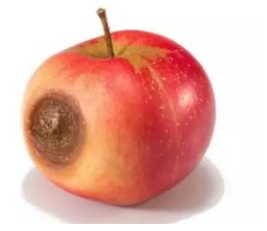

In [9]:
# 输入图片
input_image = Image.open('6.jpg')
# 可视化输入的图片
plt.imshow(input_image)
plt.axis('off')
plt.show()
# 把输入图片转化为Tensor
input_image = torchvision.transforms.ToTensor()(input_image)
input_image = torchvision.transforms.Resize((100,100))(input_image)
input_image = torch.unsqueeze(input_image,0)


In [16]:
# 实例化层的可视化类
# vgg_model.features的第0层
conv_out = LayerActivations(mymodel.vgg_model.features,0)
# 在调用register_forward_hook函数之前，需要做一次前向传播
o = mymodel.vgg_model(torch.autograd.Variable(input_image.cuda()))
# 移除掉hook
conv_out.remove()
# 把register_forward_hook捕捉到的信息赋值给act
act = conv_out.features

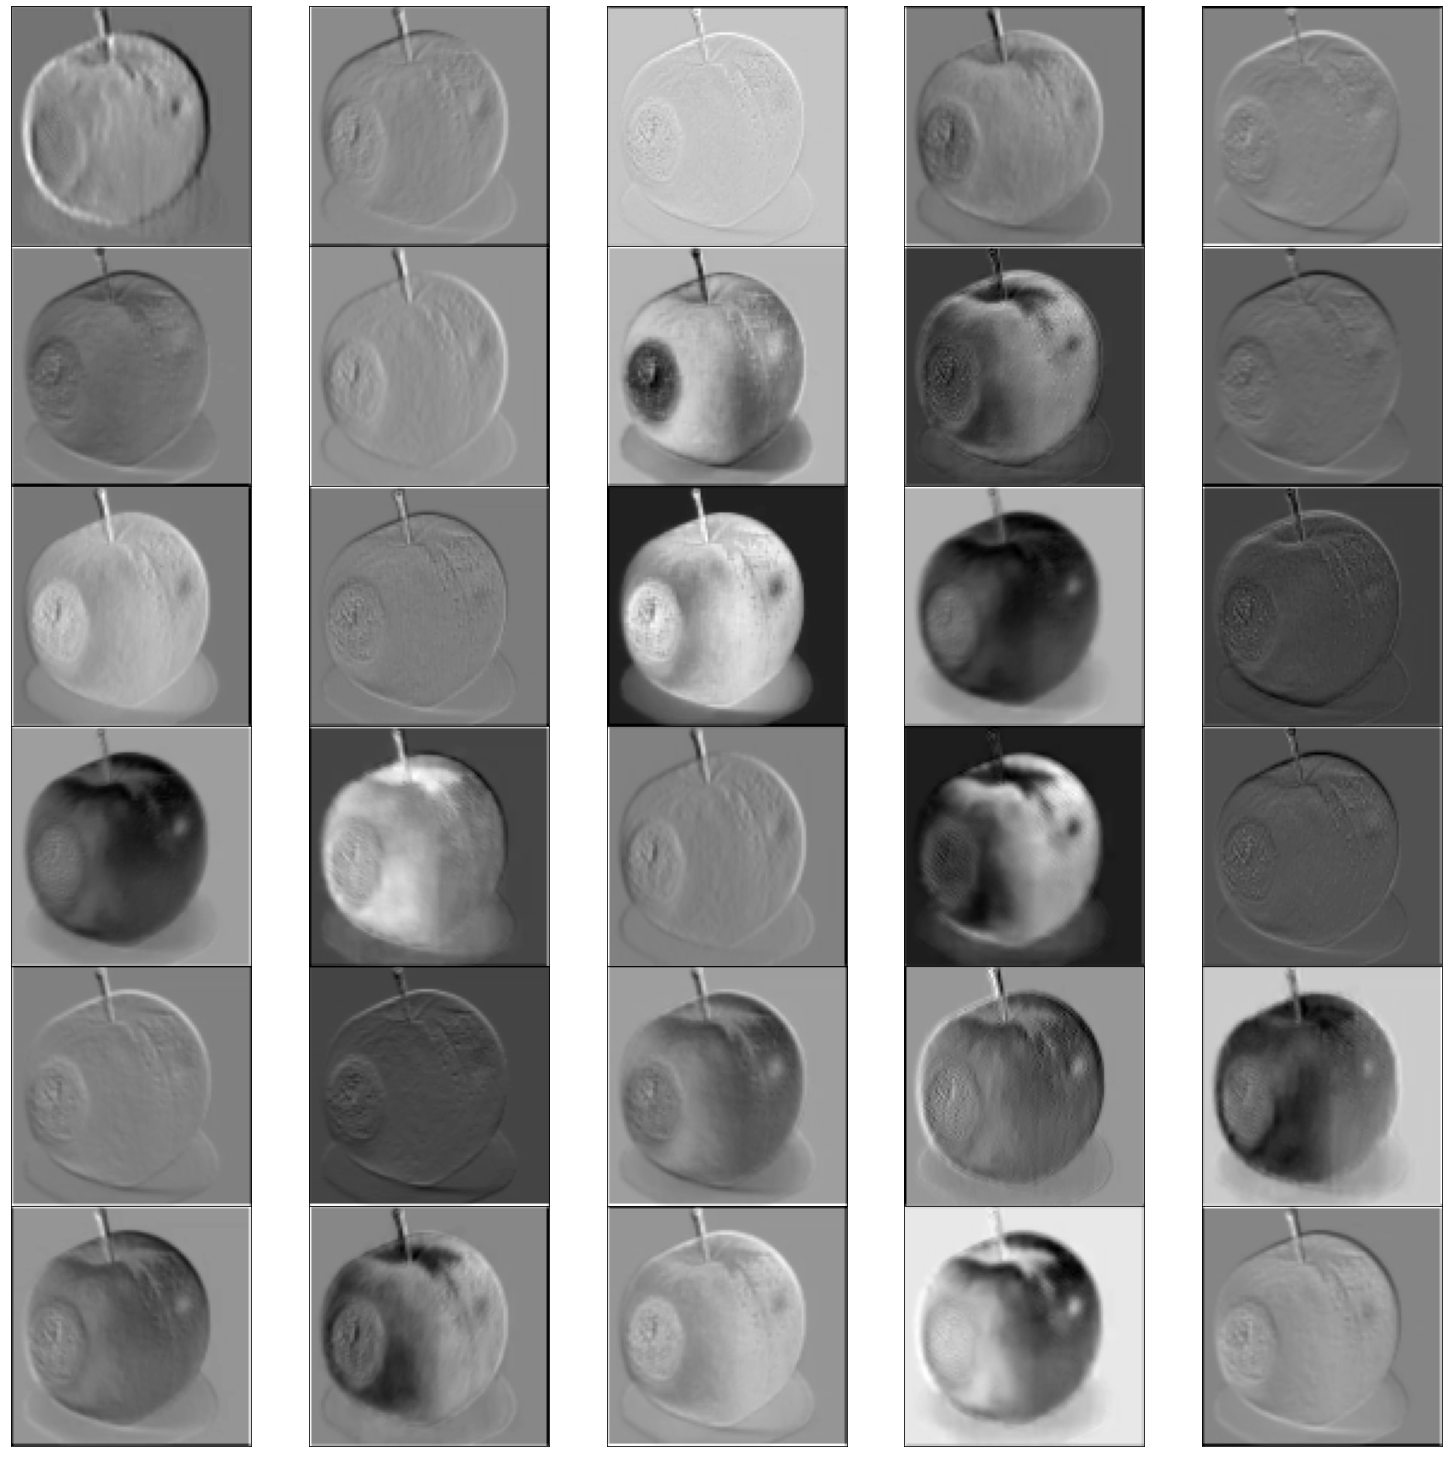

In [17]:
# 把act给可视化出来
act = act.detach()
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i],cmap='gray')

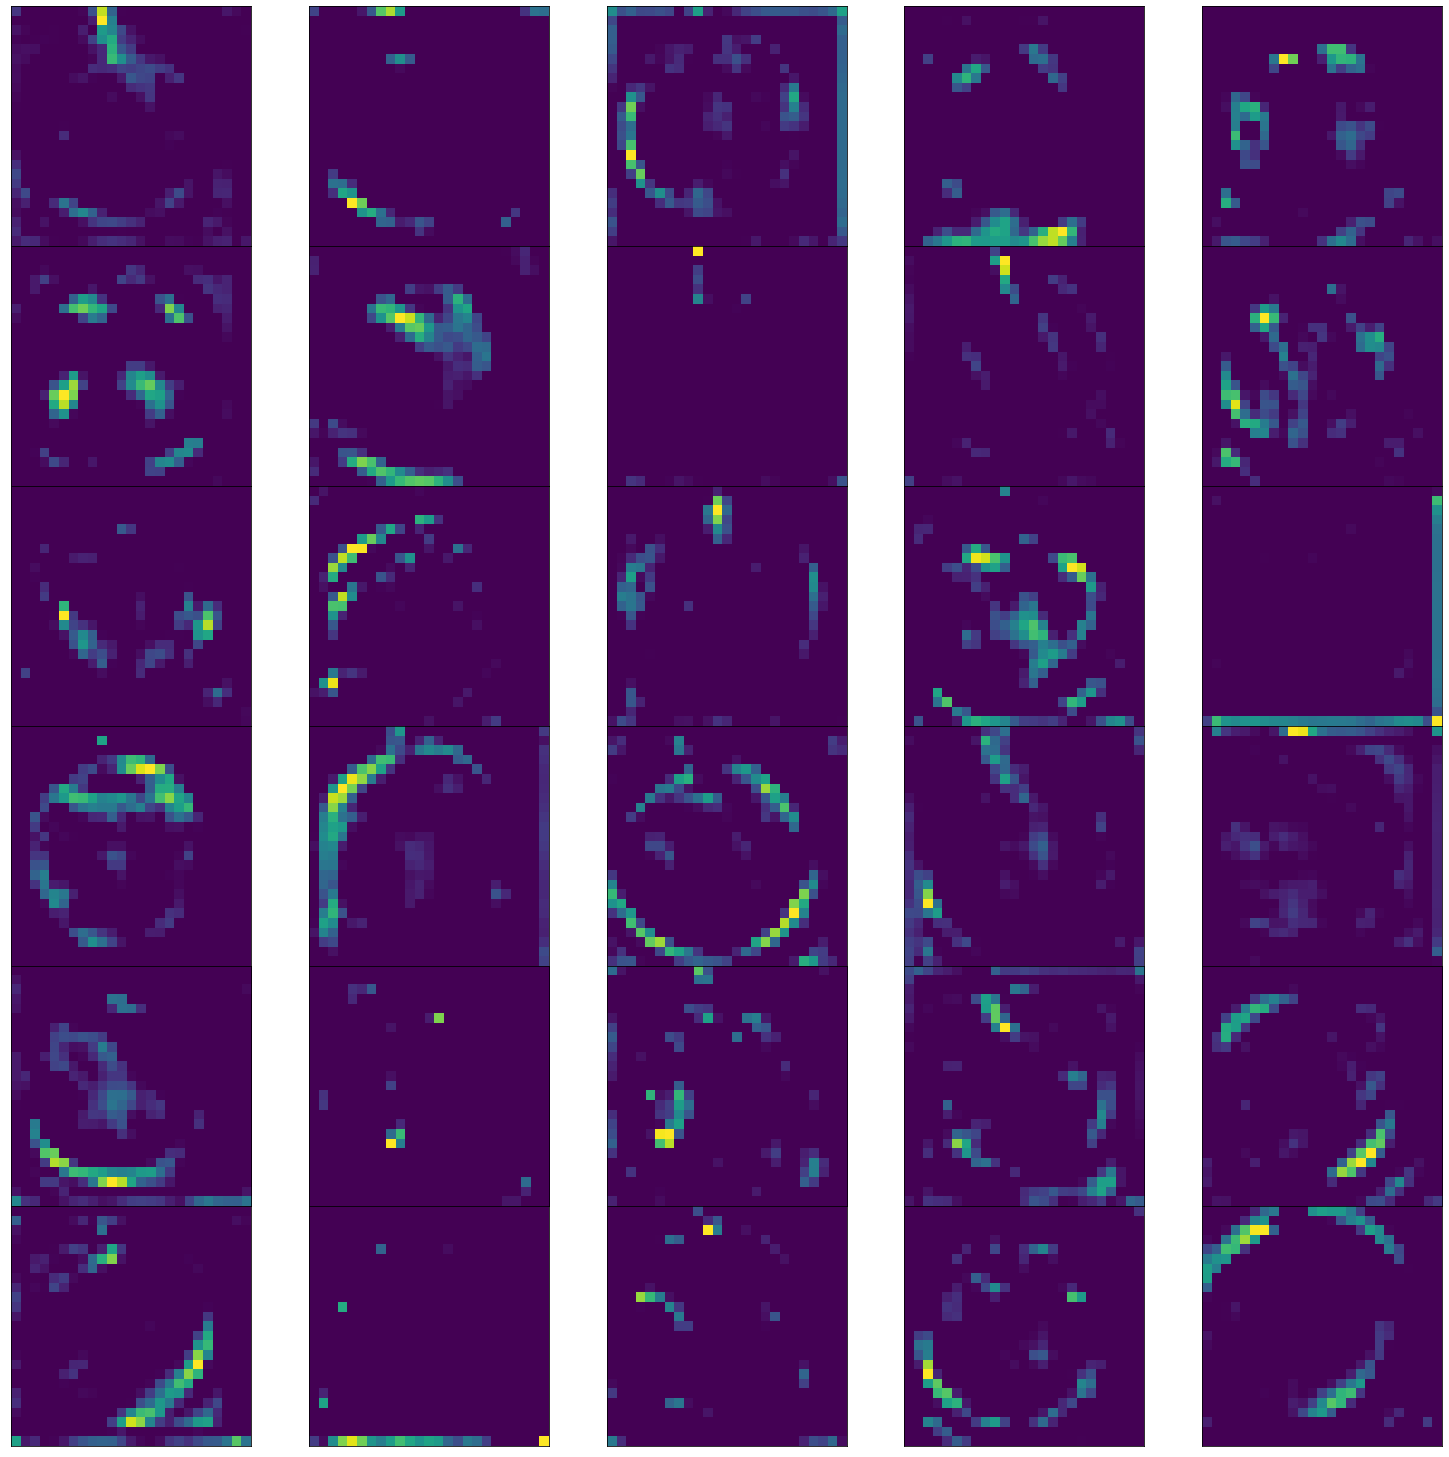

In [18]:
# vgg_model.features的第15层
conv_out = LayerActivations(mymodel.vgg_model.features,15)
o = mymodel.vgg_model(torch.autograd.Variable(input_image.cuda()))
conv_out.remove()
act = conv_out.features
act = act.detach()
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])